<a href="https://colab.research.google.com/github/m3llad0/TC3007C/blob/master/preprocesamiento_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from zipfile import ZipFile


# Serie temporal ARIMA

A continuación se realizará el preprocesamiento antes de construir un modelo temporal ARIMA, el set de datos usado será un compendio de información sobre criptomonedas. 

In [2]:
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d zsinghrahulk/crypto-currency-bitcoin-and-ethereum-data

with ZipFile('crypto-currency-bitcoin-and-ethereum-data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

!rm crypto-currency-bitcoin-and-ethereum-data.zip

cp: cannot stat 'kaggle.json': No such file or directory
  0%|                                                | 0.00/117k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 117k/117k [00:00<00:00, 2.02MB/s]


In [3]:
# Cargar set de datos
df = pd.read_csv('ETH-BTC-USD.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume,Currency
Date,,,,,,,
2018-11-14,206.533997,207.044998,174.084000,181.397003,181.397003,2.595330e+09,Etherium
2018-11-15,181.899002,184.251007,170.188995,180.806000,180.806000,2.638410e+09,Etherium
2018-11-16,180.865005,181.350006,173.126007,175.177002,175.177002,2.015330e+09,Etherium
2018-11-17,175.360001,175.850998,172.869003,174.001007,174.001007,1.832800e+09,Etherium
2018-11-18,174.175003,179.151993,174.175003,177.067001,177.067001,1.810920e+09,Etherium


## 1. Selección de variables

En el set de datos se pueden encontrar datos sobre **Etherium** y **Bitcoin**, para el análisis nos enfocaremos únicamente en el **Etherium** para realizar el preprocesamiento de los datos.

Se usará únicamente la columna *Close*, siendo que solo nos interesa el precio de cierre.

In [4]:
currency_of_interest = 'Etherium'

df_ethereum = df[df['Currency'] == currency_of_interest]

df_ethereum = df_ethereum.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close', 'Currency'])

print(df_ethereum.head())

                 Close
Date                  
2018-11-14  181.397003
2018-11-15  180.806000
2018-11-16  175.177002
2018-11-17  174.001007
2018-11-18  177.067001


## 2. Visualización de la serite temporal

Observamos una gráfica del cambio del precio de cierre a lo largo del tiempo.

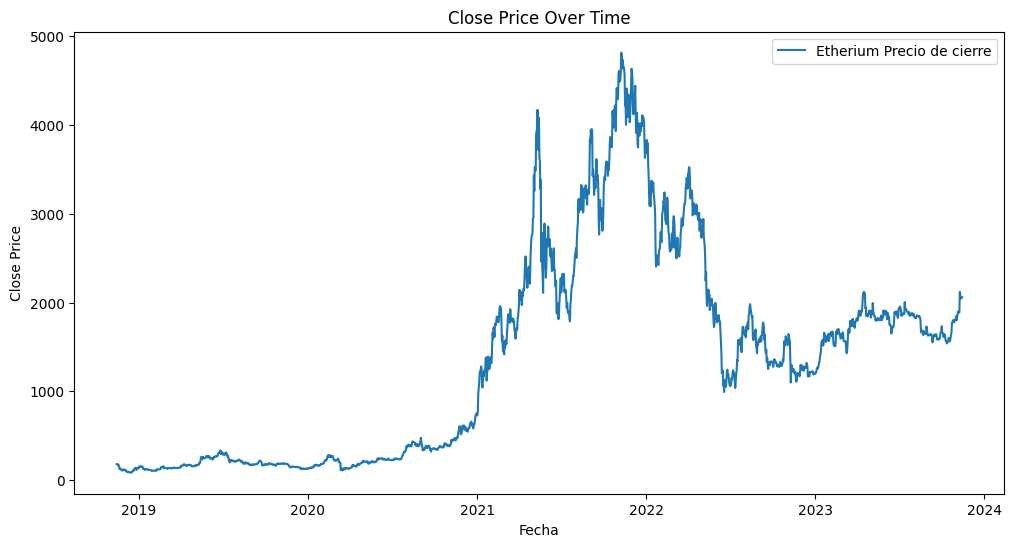

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df_ethereum, label=f'{currency_of_interest} Precio de cierre')
plt.title('Close Price Over Time')
plt.xlabel('Fecha')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## 3. Prueba de estacionariedad

Los resultados de la prueba de estacionariedad muestran que el estadístico ADF es -1.49, indicando cierta evidencia en contra de la hipótesis nula de no estacionariedad. Sin embargo, el valor p asociado es 0.54, lo que sugiere que no hay suficiente respaldo estadístico para rechazar dicha hipótesis. En conjunto, estos resultados indican que la serie temporal original de los precios de cierre de Ethereum no es estacionaria, lo que podría requerir la aplicación de técnicas de diferenciación antes de modelar con métodos como ARIMA.

In [6]:
result_adf = adfuller(df_ethereum['Close'])
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')

ADF Statistic: -1.494632557843634
p-value: 0.5361648450748814


## 4. Autocorrelación y autocorrelación parcial

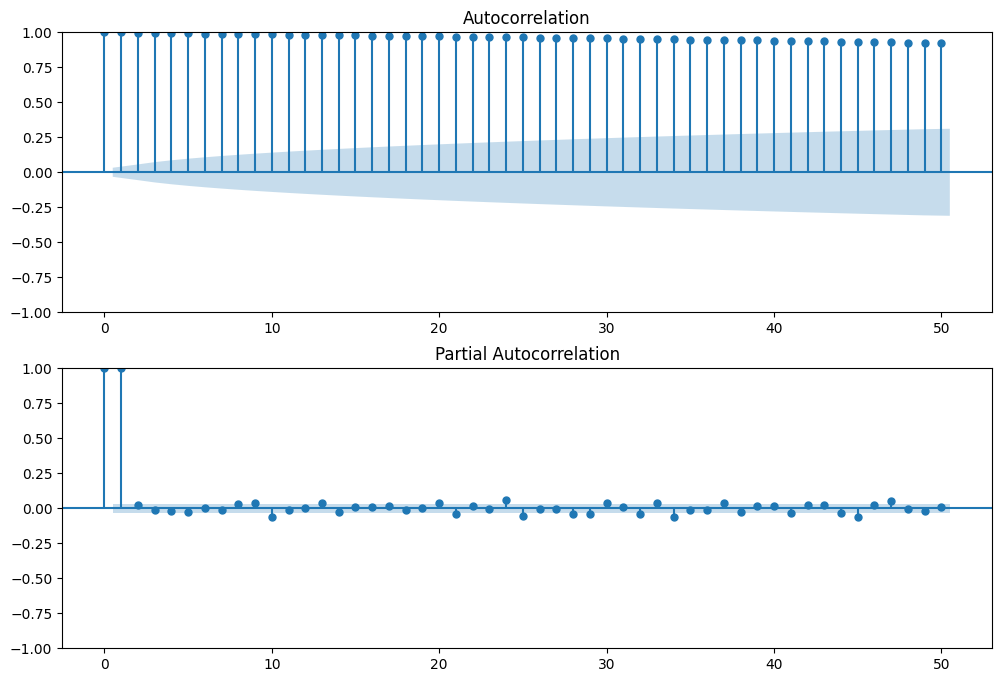

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Close'], lags=50, ax=ax1)
plot_pacf(df['Close'], lags=50, ax=ax2)
plt.show()

## 4. Diferenciación de datos
Aplicaremos una diferenciación a los datos para hacer la serie más estacionaría y estabilizar la varianza de los datos.


In [8]:
#Identificar valores que sean NaN

print("Valores NaN en la serie de datos origial: ", df_ethereum['Close'].isnull().sum())

Valores NaN en la serie de datos origial:  0


In [9]:
#Diferenciación de los datos

df_ethereum['Close_diff'] = df_ethereum['Close'].diff()  

df_ethereum = df_ethereum.dropna()
df_ethereum

,Close,Close_diff
Date,,
2018-11-15,180.806000,-0.591003
2018-11-16,175.177002,-5.628998
2018-11-17,174.001007,-1.175995
2018-11-18,177.067001,3.065994
2018-11-19,149.175003,-27.891998
...,...,...
2023-11-10,2078.289795,-42.271240
2023-11-11,2052.713867,-25.575928
2023-11-12,2045.187012,-7.526855


### Visualización de serie temporal diferenciada

Text(0, 0.5, 'Precio al cierre diferenciado')

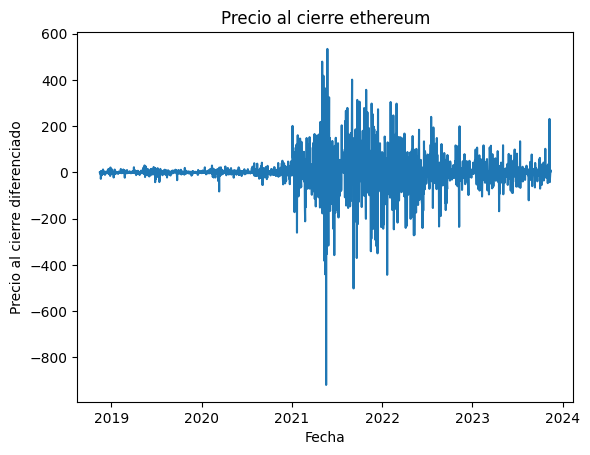

In [10]:
#visualización serie diferenciada
plt.plot(df_ethereum['Close_diff'])
plt.title("Precio al cierre ethereum")
plt.xlabel("Fecha")
plt.ylabel("Precio al cierre diferenciado")

## 5. Prueba estacionaeriedad en la serie diferenciada

Los resultados de la prueba de estacionariedad después de la diferenciación indican un estadístico ADF de -10.74, lo cual es considerablemente más negativo que antes de la diferenciación. Además, el valor p asociado es prácticamente cero (2.81e-19), proporcionando una fuerte evidencia en contra de la hipótesis nula de no estacionariedad. Estos resultados respaldan la efectividad de la diferenciación en lograr la estacionariedad, sugiriendo que la serie temporal diferenciada puede ser adecuada para modelar con métodos como ARIMA.

In [11]:
#Prueba de estacionariedad

result_diff = adfuller(df_ethereum['Close_diff'].dropna())
print("Estadisticas prueba ADF después de diferenciación", result_diff[0])
print("Valores p después de diferenciación: ", result_diff[1])

Estadisticas prueba ADF después de diferenciación -10.741354418109191
Valores p después de diferenciación:  2.812804868086303e-19


## 6. Propuesta de modelo

Se propone un modelo ARIMA(1, 1, 0) para la serie temporal de los precios de cierre de Ethereum. Los valores se eligen tras analizar la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF) de la serie temporal diferenciada. La autocorrelación significativa en el rezago 1 en ACF respalda $p = 1$, mientras que la autocorrelación parcial en el rezago 1 en PACF respalda $q=0$.  La diferenciación de primer orden ($d=1$) se aplica para lograr estacionariedad, y en conjunto, estos valores representan un equilibrio entre la complejidad del modelo y su capacidad para capturar la estructura de la serie temporal.

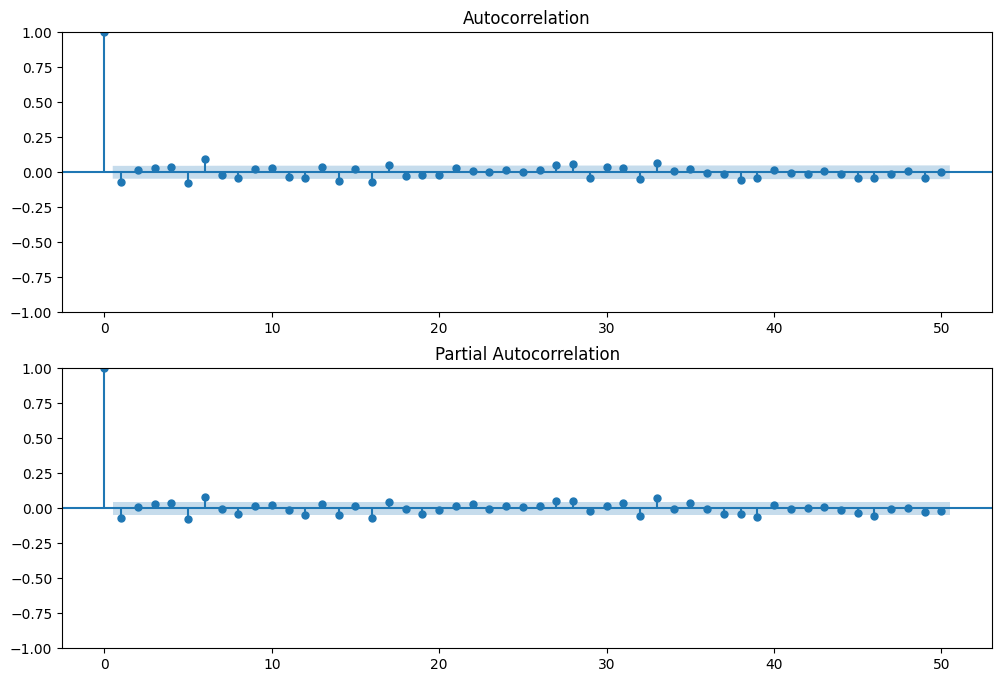

In [12]:
# Graficar ACF y PACF de la serie diferenciada
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_ethereum['Close_diff'], lags=50, ax=ax1)
plot_pacf(df_ethereum['Close_diff'], lags=50, ax=ax2)
plt.show()

In [13]:
from pmdarima import auto_arima

model = auto_arima(df_ethereum['Close'], trace=True, error_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21180.662, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21184.382, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21177.303, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21177.596, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21182.684, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21179.055, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21179.169, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21179.586, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=21175.649, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=21177.394, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21177.510, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=21175.942, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=21177.889, Time=0.15 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.310 seconds


## 7. Construcción del modelo

In [14]:
print(model.summary())  

train_size = int(len(df_ethereum) * 0.8)
train, test = df_ethereum['Close'][:train_size], df_ethereum['Close'][train_size:]


model.fit(train)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1826
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -10585.825
Date:                Sat, 18 Nov 2023   AIC                          21175.649
Time:                        19:01:33   BIC                          21186.668
Sample:                    11-15-2018   HQIC                         21179.714
                         - 11-14-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0703      0.013     -5.547      0.000      -0.095      -0.045
sigma2      6396.9018     70.937     90.177      0.000    6257.867    6535.936
Ljung-Box (L1) (Q):                   0.00   Jarque-

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

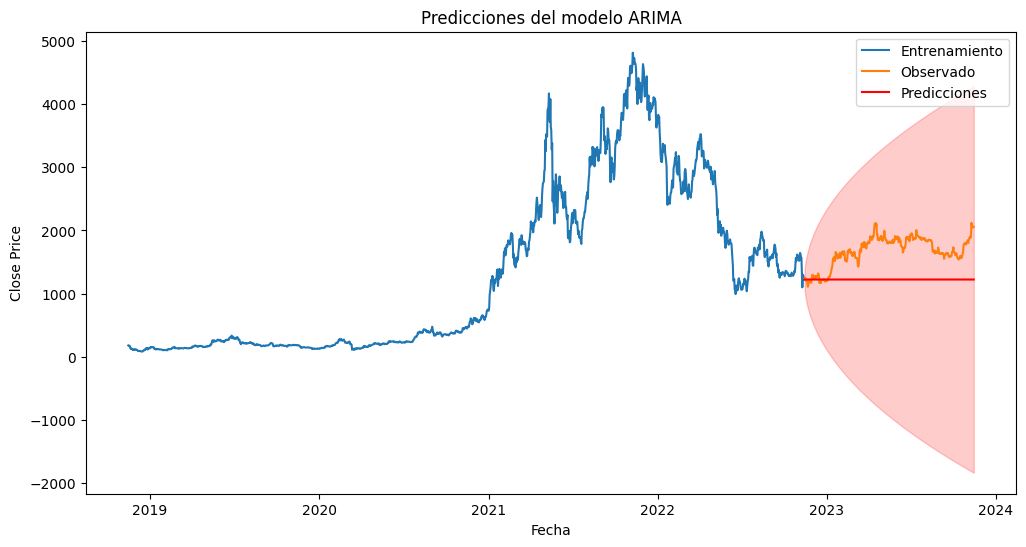

In [20]:
predictions = model.predict(len(test), return_conf_int=True)

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Observado')
plt.plot(test.index, predictions[0], label='Predicciones', color='red')  # Acceder a las predicciones directamente
plt.fill_between(test.index, predictions[1][:, 0], predictions[1][:, 1], color='red', alpha=0.2)  # Acceder a los intervalos de confianza
plt.title('Predicciones del modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Close Price')
plt.legend()
plt.show()


Mean Absolute Error (MAE): 451.79871659436725
Mean Squared Error (MSE): 253899.0719354783


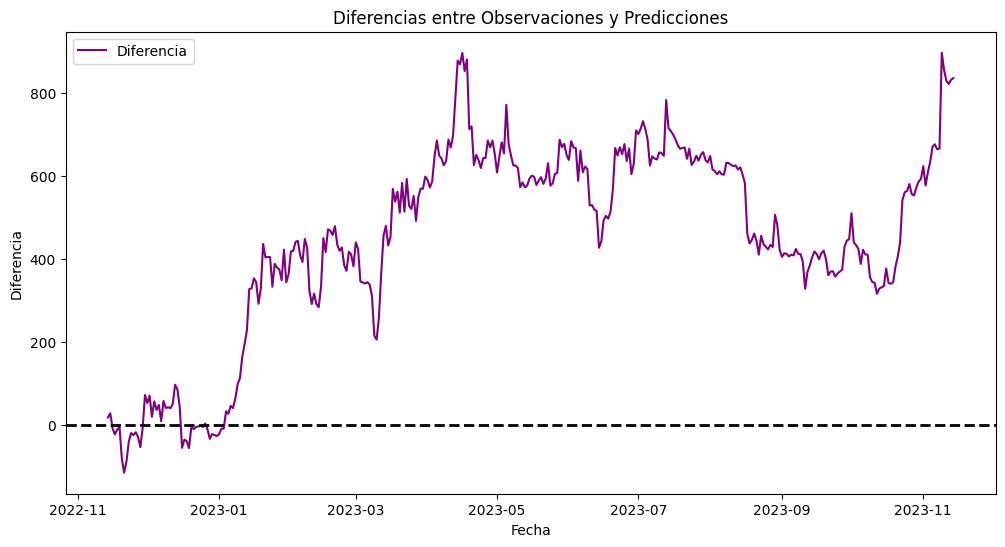

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular el Error Absoluto Medio (MAE)
mae = mean_absolute_error(test, predictions[0])
mse = mean_squared_error(test, predictions[0])

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

# Visualizar las diferencias entre observaciones reales y predicciones
plt.figure(figsize=(12, 6))
plt.plot(test.index, test - predictions[0], label='Diferencia', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=2)
plt.title('Diferencias entre Observaciones y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Diferencia')
plt.legend()
plt.show()

/home/diego/Diego/Tec/IA/TC3007C/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/diego/Diego/Tec/IA/TC3007C/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91022D+00    |proj g|=  1.10201D-01

At iterate    5    f=  5.88833D+00    |proj g|=  3.57335D-02

At iterate   10    f=  5.88511D+00    |proj g|=  4.27518D-03

At iterate   15    f=  5.88460D+00    |proj g|=  1.07175D-02

At iterate   20    f=  5.88267D+00    |proj g|=  3.30733D-02

At iterate   25    f=  5.88142D+00    |proj g|=  1.07344D-02

At iterate   30    f=  5.88137D+00    |proj g|=  2.99468D-04

At iterate   35    f=  5.88136D+00    |proj g|=  5.20347D-03

At iterate   40    f=  5.88121D+00    |proj g|=  3.63901D-02

At iterate   45    f=  5.88116D+00    |proj g|=  4.69364D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/diego/Diego/Tec/IA/TC3007C/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


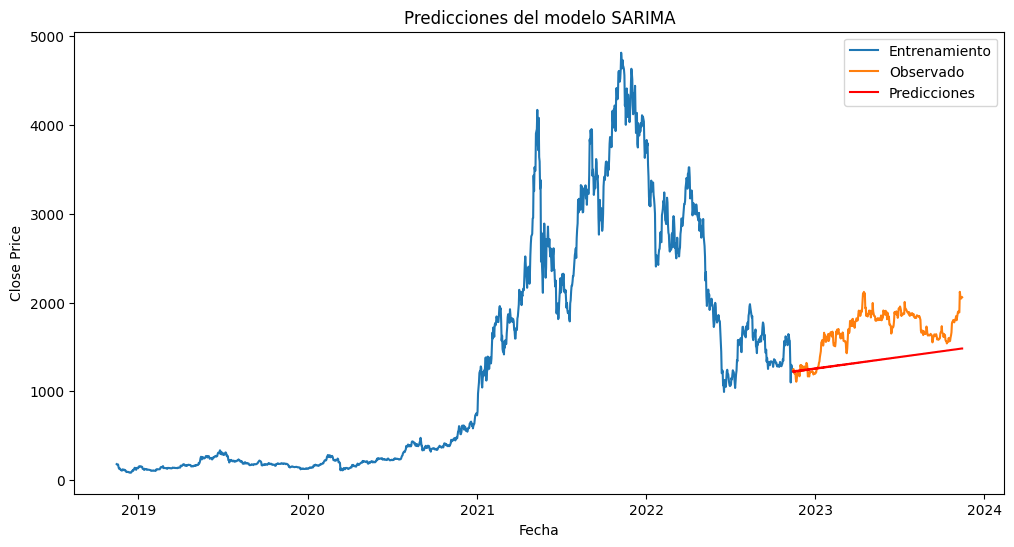

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Crear y ajustar el modelo SARIMA
sarima_model = SARIMAX(train, order=(2, 2, 3))
sarima_result = sarima_model.fit()


# Realizar predicciones
sarima_pred = sarima_result.predict(start=len(train), end=len(df_ethereum)-1, typ='levels')

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Observado')
plt.plot(test.index, sarima_pred, label='Predicciones', color='red')
plt.title('Predicciones del modelo SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Close Price')
plt.legend()
plt.show()

